In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima, ADFTest
from sklearn.metrics import r2_score,mean_squared_error 

plt.rcParams["figure.figsize"] = (16,9)

In [3]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
ticker = "PNC"
df = yf.download(ticker, start="2020-01-01", end="2022-12-31")


[*********************100%***********************]  1 of 1 completed


In [5]:
# df = df.resample('W').agg({'Open':'first','High':'max','Low':'min','Close':'last','Adj Close':'last'})

In [6]:
adf_test = ADFTest(alpha = 0.05) # CL: 95%
adf_test.should_diff(df['Close']) # not stationary


(0.7414371196614109, True)

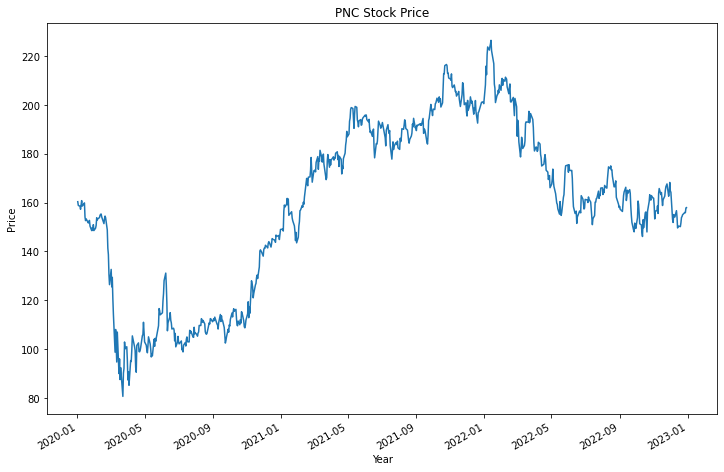

In [7]:
df['Close'].plot(figsize=(12, 8))
plt.xlabel("Year")
plt.ylabel("Price")
plt.title(f"{ticker} Stock Price")
plt.show()

In [8]:
# split train test
train_data = df[:int(df.shape[0] * 0.8)]
test_data = df[int(df.shape[0] * 0.8)-1:]

In [9]:


y_actual = test_data['Close']
model = auto_arima(train_data['Close'],trace = True, error_action='ignore',suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3211.052, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3225.664, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3222.379, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3222.735, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3223.665, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3225.600, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3225.646, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3223.768, Time=0.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3224.049, Time=0.98 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3227.268, Time=1.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3227.142, Time=2.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3209.053, Time=1.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3

In [10]:
# model summary 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  604
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1599.527
Date:                Tue, 28 Feb 2023   AIC                           3209.053
Time:                        19:39:33   BIC                           3231.063
Sample:                             0   HQIC                          3217.619
                                - 604                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7314      0.037    -46.632      0.000      -1.804      -1.659
ar.L2         -0.9236      0.041    -22.743      0.000      -1.003      -0.844
ma.L1          1.6611      0.051     32.339      0.000       1.560       1.762
ma.L2          0.8498      0.054     15.827      0.000       0.745       0.955
sigma2        11.7863      0.508     23.208      0.000      10.791      12.782
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                77.27
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.22
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
# forcasting

future_forecast = model.predict(n_periods=len(test_data), return_conf_int = True, alpha=0.5)

range_df = pd.DataFrame(future_forecast[1],columns=['low_95','high_95'])
future_forecast = pd.DataFrame(future_forecast[0],columns=['prediction']).set_index(test_data.index)

c:\Users\SARAN\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


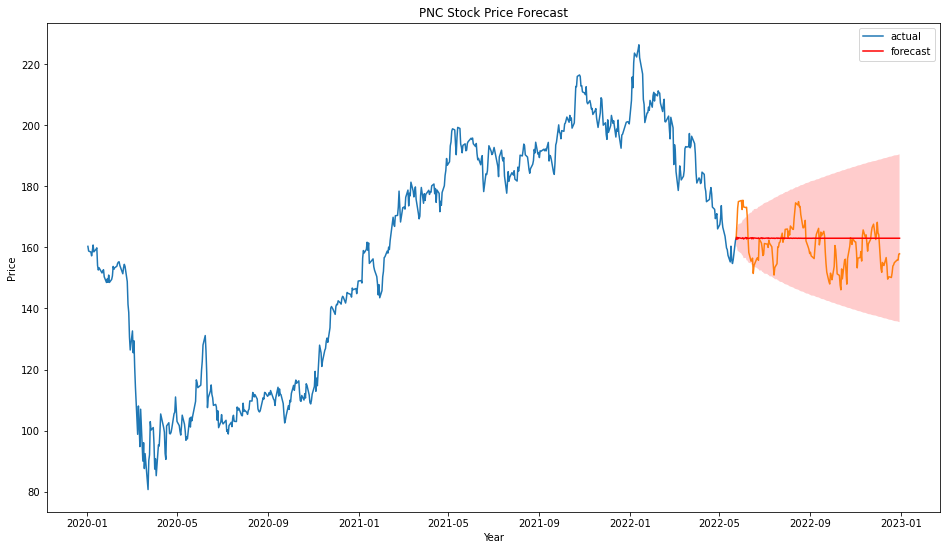

Test MSE : 53.529165620379366
Test R-score: -0.15189780217642324


In [12]:
plt.plot(train_data['Close'],label = 'actual')
plt.plot(y_actual)
plt.plot(future_forecast, color='red',label = "forecast")
plt.fill_between(test_data.index,range_df['low_95'],range_df['high_95'],alpha = 0.2, facecolor = 'r')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title(f"{ticker} Stock Price Forecast")
plt.legend()
plt.show()
mse = mean_squared_error(y_actual,future_forecast.values)
r_score = r2_score(y_actual,future_forecast)
print("Test MSE :",mse)
print("Test R-score:", r_score)